# Classifying cars with Decisions Trees, Random Forests, and Ensemble Methods

##### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, \
    VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, ExtraTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score
import numpy as np

##### Importing the data

In [2]:
data = pd.read_csv('C:/Users/Nicolas/Documents/Scraping/thecarconnection/full_dataset.csv', 
                 index_col=0).sample(frac=1, random_state=42).reset_index(drop=True)
dataset = data.copy()

Taking a peek at the data

In [3]:
data.drop(['Style Name', 'Body Style', 'EPA Classification', 'Drivetrain'], axis=1).head()

,MSRP,Make,Model,Passenger Capacity,Passenger Doors,Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Front Leg Room (in),Second Shoulder Room (in),...,Rear Wheel Size,Front Wheel Size,Tire Rating,Tire Width Ratio,Wheel Size Ratio,Tire Ratio,Year,Country,Country Code,Category
0,30034.0,GMC,Sierra 2500HD,6.0,2.0,65.2,41.0,33.7,41.30,66.3,...,16.0,16.0,R,1.0,1.0,7.0,2002.0,USA,6.0,Pickup
1,19515.0,Ford,Ranger,5.0,2.0,54.5,39.2,39.1,42.40,40.0,...,15.0,15.0,R,1.0,1.0,7.0,2010.0,USA,6.0,Pickup
2,24595.0,Subaru,Outback,5.0,4.0,56.3,40.8,37.8,43.00,56.1,...,17.0,17.0,R,1.0,1.0,6.0,2010.0,Japan,2.0,Car
3,56600.0,Porsche,Cayenne,5.0,4.0,58.9,39.6,36.0,41.86,56.7,...,18.0,18.0,V,1.0,1.0,5.0,2014.0,Germany,0.0,SUV
4,21795.0,Mazda,CX-5,5.0,4.0,57.5,40.1,39.3,41.00,55.5,...,17.0,17.0,H,1.0,1.0,6.0,2016.0,Japan,2.0,SUV


In [9]:
print('The data contains %i rows and %i columns, across %i different makes.'%(data.shape[0], 
                                data.shape[1], len(data.Make.value_counts())))

The data contains 31237 rows and 81 columns, across 43 different makes.



## Preprocessing

##### Making sure the data is balanced

In [16]:
data['EPA Classification'].value_counts().head(10)

None             10555
Compact           4089
Midsize           3585
SUV 4WD           2150
Subcompact        1762
Large             1626
SUV 2WD           1285
Small SUV 4WD     1258
Two Seater        1067
Small SUV 2WD      881
Name: EPA Classification, dtype: int64

In [17]:
suv_awd = data.loc[data['EPA Classification'] == 'SUV 4WD'].sample(n=1000)
midsized_car = data.loc[data['EPA Classification'] == 'Midsize'].sample(n=1000)
compact_car = data.loc[data['EPA Classification'] == 'Compact'].sample(n=1000)
subcompact_car = data.loc[data['EPA Classification'] == 'Subcompact'].sample(n=1000)
large_car = data.loc[data['EPA Classification'] == 'Large'].sample(n=1000)
suv_2wd = data.loc[data['EPA Classification'] == 'SUV 2WD'].sample(n=1000)
small_suv_4wd = data.loc[data['EPA Classification'] == 'Small SUV 4WD'].sample(n=1000)
two_seater = data.loc[data['EPA Classification'] == 'Two Seater'].sample(n=1000)

In [18]:
df = pd.concat([suv_awd, compact_car, midsized_car, subcompact_car, large_car, suv_2wd, small_suv_4wd, two_seater], 
               axis=0, sort=False).sample(frac=1)

Double checking the balanced data

In [19]:
df['EPA Classification'].value_counts()

Large            1000
SUV 4WD          1000
Small SUV 4WD    1000
Two Seater       1000
SUV 2WD          1000
Subcompact       1000
Midsize          1000
Compact          1000
Name: EPA Classification, dtype: int64

Text(0.5, 1.0, 'Pie Chart of Car Types')

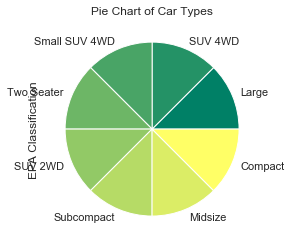

In [20]:
df['EPA Classification'].value_counts().plot(kind='pie', cmap='summer')
plt.title('Pie Chart of Car Types')

##### Separating the `x` and `y`

In [21]:
X = df.loc[:, ['Drivetrain', 'Passenger Capacity', 'Passenger Doors', 'Body Style',
       'EPA Classification', 'Front Shoulder Room (in)',
       'Front Head Room (in)', 'Second Leg Room (in)', 'Front Leg Room (in)',
       'Second Shoulder Room (in)', 'Second Head Room (in)',
       'Height, Overall (in)', 'Wheelbase (in)', 'Width, Max w/o mirrors (in)',
       'Fuel Tank Capacity, Approx (gal)', 'EPA Fuel Economy Est - Hwy (MPG)',
       'EPA Fuel Economy Est - City (MPG)', 'Fuel System',
       'Third Gear Ratio (:1)', 'First Gear Ratio (:1)',
       'Fourth Gear Ratio (:1)', 'Second Gear Ratio (:1)',
       'Front Brake Rotor Diam x Thickness (in)',
       'Rear Brake Rotor Diam x Thickness (in)', 'Steering Type',
       'Turning Diameter - Curb to Curb', 'Rear Wheel Material',
       'Suspension Type - Front', 'Air Bag-Frontal-Driver',
       'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear',
       'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 'Brakes-ABS',
       'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control', 'Other Features', 'Basic Miles/km', 'Basic Years',
       'Corrosion Miles/km', 'Corrosion Years', 'Drivetrain Miles/km',
       'Drivetrain Years', 'Roadside Assistance Miles/km',
       'Roadside Assistance Years', 'Hybrid Engine', 'Gears', 'Net Horsepower',
       'Net Horsepower RPM', 'Net Torque', 'Net Torque RPM', 'Cylinders',
       'Engine Configuration', 'Displacement (L)', 'Displacement (cc)',
       'Rear Tire Width', 'Front Tire Width', 'Rear Wheel Size',
       'Front Wheel Size', 'Tire Rating', 'Tire Width Ratio',
       'Wheel Size Ratio', 'Tire Ratio', 'Year', 'Country',
       'Category']]

Selecting the target variable

In [24]:
y = df['EPA Classification']

In [25]:
y[:10]

28605          SUV 4WD
12769       Two Seater
25297    Small SUV 4WD
3338           SUV 4WD
5623             Large
25878          SUV 4WD
894            SUV 2WD
8425             Large
17162          SUV 2WD
851            SUV 2WD
Name: EPA Classification, dtype: object

##### One hot encoding certain variables

In [26]:
specs_to_dummies = ['Drivetrain', 'Fuel System', 'Steering Type', 'Rear Wheel Material',
                   'Suspension Type - Front', 'Engine Configuration', 'Tire Rating', 'Country',
                   'Category']

for item in specs_to_dummies:
    dummies = pd.get_dummies(X[item], prefix_sep=': ', prefix=item)
    X = X.drop(item, axis=1)
    X = pd.concat([X, dummies], sort=False, axis=1)
X = X.reset_index(drop=True)

specs_to_one_two = ['Air Bag-Frontal-Driver', 'Air Bag-Frontal-Passenger', 'Air Bag-Passenger Switch (On/Off)',
       'Air Bag-Side Body-Front', 'Air Bag-Side Body-Rear', 'Air Bag-Side Head-Front', 'Air Bag-Side Head-Rear', 
       'Brakes-ABS', 'Child Safety Rear Door Locks', 'Daytime Running Lights',
       'Traction Control', 'Night Vision', 'Rollover Protection Bars',
       'Fog Lamps', 'Parking Aid', 'Tire Pressure Monitor', 'Back-Up Camera',
       'Stability Control']

for item in specs_to_one_two:
    dummies = pd.get_dummies(X[item], prefix_sep=': ', prefix=item, drop_first=True)
    X = X.drop(item, axis=1)
    X = pd.concat([X, dummies], sort=False, axis=1)
X = X.reset_index(drop=True)

X.drop(['Body Style', 'EPA Classification', 'Other Features'], axis=1, inplace=True)

Changing the data type

In [27]:
X = X.astype('float32')

Checking what it looks like now...

In [28]:
X.head()

,Passenger Capacity,Passenger Doors,Front Shoulder Room (in),Front Head Room (in),Second Leg Room (in),Front Leg Room (in),Second Shoulder Room (in),Second Head Room (in),"Height, Overall (in)",Wheelbase (in),...,Child Safety Rear Door Locks: Yes,Daytime Running Lights: Yes,Traction Control: Yes,Night Vision: Yes,Rollover Protection Bars: Yes,Fog Lamps: Yes,Parking Aid: Yes,Tire Pressure Monitor: Yes,Back-Up Camera: Yes,Stability Control: Yes
0,5.0,4.0,53.500000,39.799999,33.700001,43.599998,53.599998,39.799999,65.000000,99.400002,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.0,2.0,52.500000,36.299999,35.099998,44.299999,53.000000,36.400002,46.099998,99.599998,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,4.0,57.900002,39.299999,39.400002,41.000000,58.099998,38.500000,69.000000,115.300003,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3,5.0,4.0,55.700001,40.900002,40.200001,41.200001,55.900002,40.099998,69.300003,112.500000,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,5.0,4.0,59.299999,41.400002,41.799999,40.599998,57.700001,39.000000,61.400002,120.699997,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


##### Splitting the data into train and test sets

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2e-1)

### #1 Classifier: Decision Tree 

Fitting the model to the training data

In [30]:
tree_clf = DecisionTreeClassifier(max_depth=None, max_features=None, max_leaf_nodes=None, min_samples_leaf=1)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Making predictions

In [31]:
y_pred = tree_clf.predict(X_test)

Evaluating the predictions

In [32]:
trees_accuracy = accuracy_score(y_pred, y_test)

In [33]:
print('With no parameter tuning, we have reached a %f%% accuracy with a decision tree'%(trees_accuracy*1_00))

With no parameter tuning, we have reached a 98.250000% accuracy with a decision tree


Let's see what were the most important features

In [34]:
imp = pd.DataFrame(tree_clf.feature_importances_, index=[X.columns], 
             columns=['Importance']).sort_values(by='Importance', ascending=False).head(30)
imp.head(8)

,Importance
"Height, Overall (in)",0.158507
Passenger Capacity,0.144455
Second Shoulder Room (in),0.110121
Front Shoulder Room (in),0.101879
Steering Type: Rack Pinion,0.099969
Drivetrain: Front Wheel Drive,0.082920
Drivetrain: Rear Wheel Drive,0.052212
"Fuel Tank Capacity, Approx (gal)",0.048008


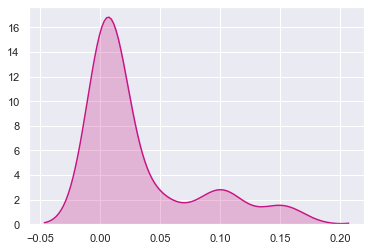

In [35]:
sns.distplot(imp, hist=False, kde_kws={'shade':True}, color='mediumvioletred')
plt.show()

##### Decision tree visualization

What's nice with decision trees is that you can visualize them every step of the way. Let's make a very simple model so we can see the decision making

In [36]:
sns.set()
export_graphviz(
    tree_clf,
    out_file=r'C:\Users\Nicolas\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin/graphviz/cars_tree.dot',
    feature_names=X_train.columns,
    class_names=y.unique(),
    rounded=True,
    max_depth=3,
    filled=True,
    rotate=True)

In [37]:
# type this into the command line: 
# dot -Tpng C:\Users\Nicolas\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz/cars_tree.dot -o 
# C:\Users\Nicolas\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz/cars_tree.jpg

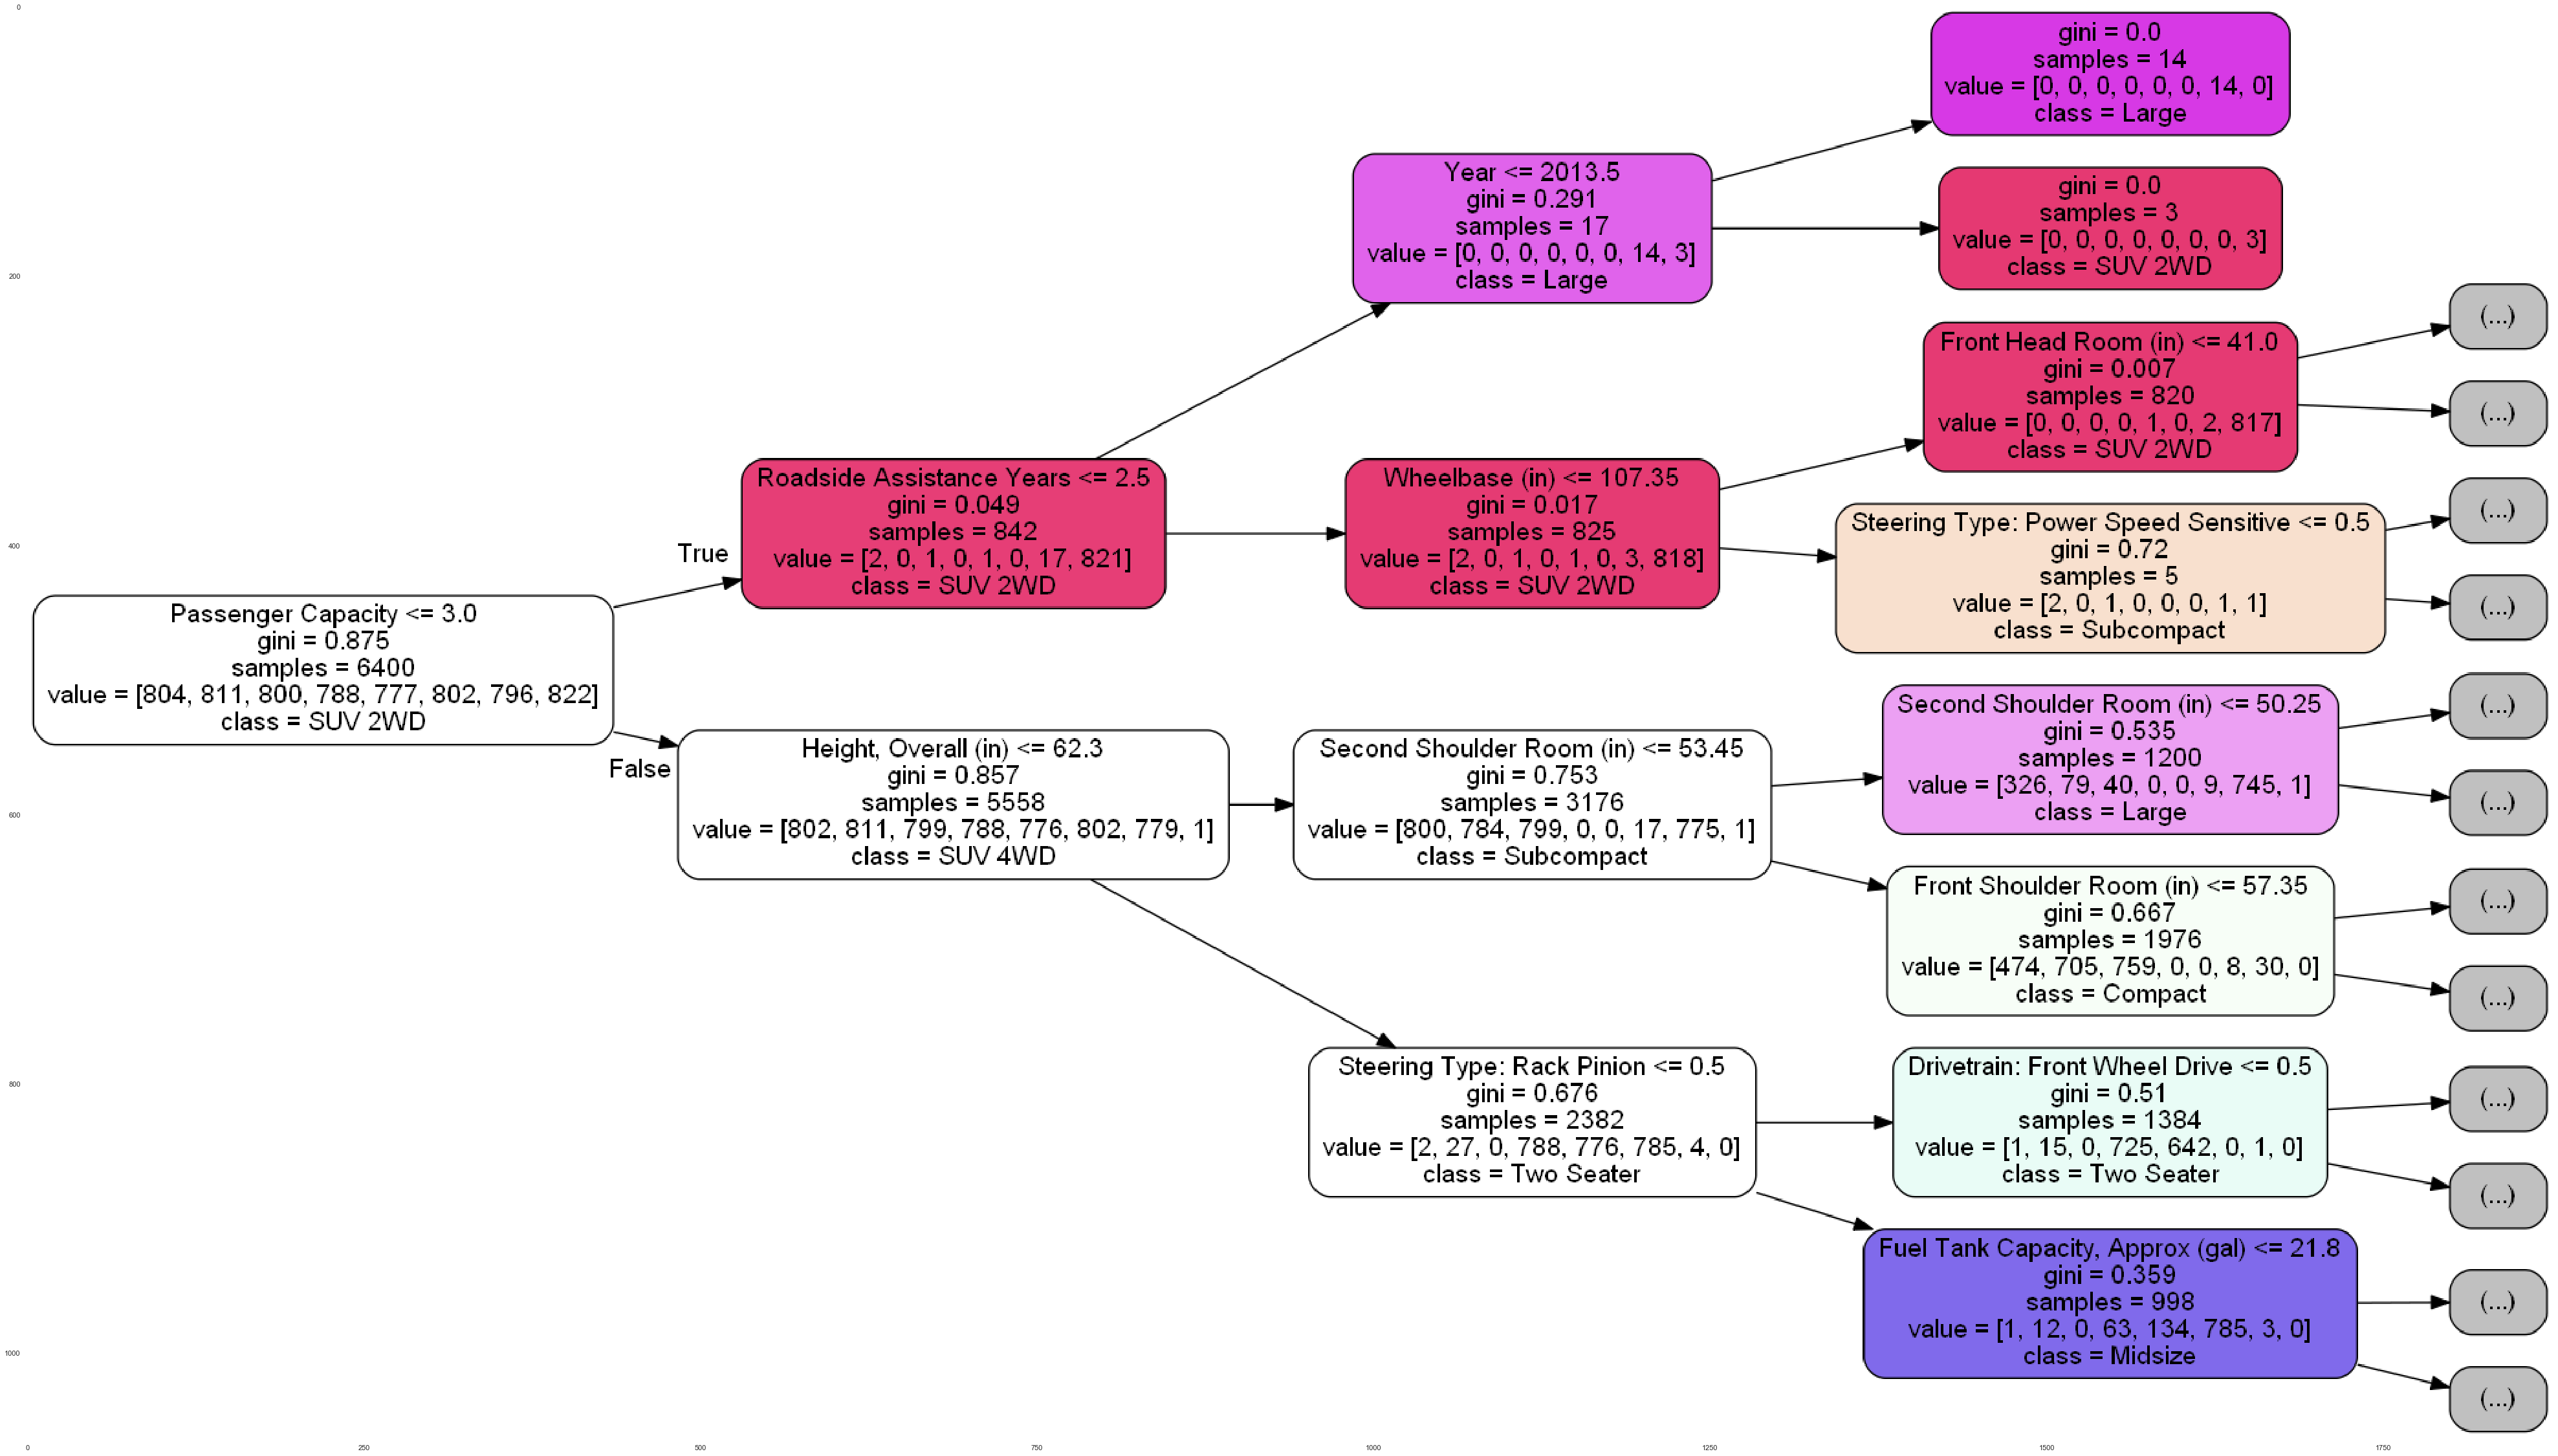

In [38]:
tree = plt.imread(r'C:\Users\Nicolas\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz/cars_tree.jpg')
plt.figure(figsize = (70,70))
plt.grid(None)
plt.imshow(tree, interpolation='nearest')

##### We will make a randomized search for the best parameters (for the real model)

Let's see what parameters are tunable

In [39]:
params = tree_clf.get_params().keys()
params

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

Let's select a bunch of them

In [40]:
dict_to_be_randomized = {'max_depth':np.round(np.linspace(80, 90, 1)), 
                         'max_features':np.arange(79, 84), 
                         'max_leaf_nodes':np.round(np.arange(145, 153, 1)), 
                         'min_samples_leaf':np.arange(1, 3),
                         'presort':[True, False]}

Let's define the search

In [41]:
rand_search = RandomizedSearchCV(tree_clf, dict_to_be_randomized, n_iter=80, scoring='accuracy', n_jobs=-1, refit=True, 
                   return_train_score=True, cv=5, verbose=2)

Let's run the search!

In [110]:
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   29.0s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [111]:
y_pred = rand_search.best_estimator_.predict(X_test)
tree_accuracy = accuracy_score(y_pred, y_test)
print('With a randomized search, we have reached a %f%% accuracy with a decision tree'%(tree_accuracy*1_00))

With a randomized search, we have reached a 97.500000% accuracy with a decision tree


The best parameters:

In [112]:
rand_search.best_params_

{'presort': True,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 148,
 'max_features': 80,
 'max_depth': 80.0}

In [113]:
rand_search.best_score_

0.97109375

Since the train and test scores are very close, it doesn't seem like the model is overfitting the data. Regularization methods could have been reducing the `max_depth`, increasing the `min_samples_leaf`, decreasing the `max_features`, etc.

In [114]:
acc_df = pd.DataFrame([trees_accuracy], index=['Decision Tree'], columns=['Accuracy'])
acc_df

,Accuracy
Decision Tree,0.9825


Text(0.5, 1, 'Accuracy of various models')

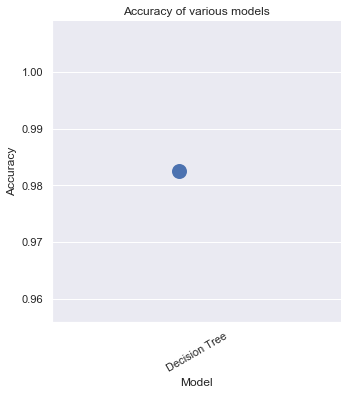

In [115]:
g = sns.catplot(data=acc_df.reset_index(), x='index', y='Accuracy', s=15)
plt.xlabel('Model')
g.set_xticklabels(rotation=30)
plt.title('Accuracy of various models')

### #2 Classifier: Random Forest 

In [118]:
forest_clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True, min_samples_leaf=2, 
                                    max_depth=22, max_features=80) 

Fitting the model

In [119]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=22, max_features=80, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

Making predictions

In [120]:
y_pred = forest_clf.predict(X_test)

Evaluating the predictions

In [121]:
forest_accuracy = accuracy_score(y_test, y_pred)
forest_accuracy

0.98625

In [122]:
forest_clf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=22, max_features=80, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)>

That's an even better score

Since Random Forests take just a sample of the data, we can use the rest of the data (the out-of-bag data, or _oob_) as a test sample. That way, we can estimate the performance of the model before we make predictions

In [123]:
forest_clf.oob_score_

0.98609375

It's almost the same! We didn't even really need a holdout (test) set!

In [124]:
acc_df = pd.concat([acc_df, pd.DataFrame([forest_accuracy], columns=['Accuracy'], index=['Random Forest'])], sort=False, axis=0)
acc_df

,Accuracy
Decision Tree,0.98250
Random Forest,0.98625


Text(0.5, 1, 'Accuracy of various models')

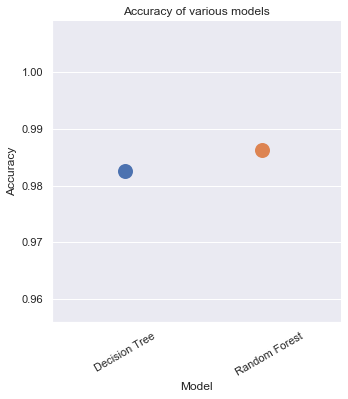

In [125]:
g = sns.catplot(data=acc_df.reset_index(), x='index', y='Accuracy', s=15)
plt.xlabel('Model')
g.set_xticklabels(rotation=30)
plt.title('Accuracy of various models')

### #3 Classifier: Extra Tree 

Instead of splitting the attribute to get the most _information gain_ like normal decision trees, extra trees split the attribute randomly

Instantiating the class

In [126]:
extra_clf = ExtraTreeClassifier()

Fitting the model

In [127]:
extra_clf.fit(X_train, y_train)

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=None,
                    splitter='random')

Making predictions

In [128]:
y_pred = extra_clf.predict(X_test)

Evaluating the predictions

In [129]:
accuracy_score(y_pred, y_test)

0.941875

Preparing the grid search parameters

In [130]:
params = {
    'max_depth':range(25, 35),
    'max_features':range(60, 70)     
         }

Launching the grid search

In [131]:
grid = GridSearchCV(extra_clf, params, n_jobs=-1, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ExtraTreeClassifier(class_weight=None, criterion='gini',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           random_state=None,
                                           splitter='random'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': range(25, 35),
                         'max_features': range(60, 70)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [132]:
grid.best_estimator_

ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=28,
                    max_features=65, max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, random_state=None,
                    splitter='random')

Evaluating the best model according to the grid search

In [133]:
y_pred = grid.best_estimator_.predict(X_test)
extra_accuracy = accuracy_score(y_pred, y_test)
print('With extra trees, we have reached a %f%% accuracy'%(extra_accuracy*1_00))

With extra trees, we have reached a 97.687500% accuracy


In [134]:
acc_df = pd.concat([acc_df, pd.DataFrame([extra_accuracy], columns=['Accuracy'], index=['Extra Trees'])], sort=False, axis=0)
acc_df

,Accuracy
Decision Tree,0.982500
Random Forest,0.986250
Extra Trees,0.976875


Text(0.5, 1, 'Accuracy of various models')

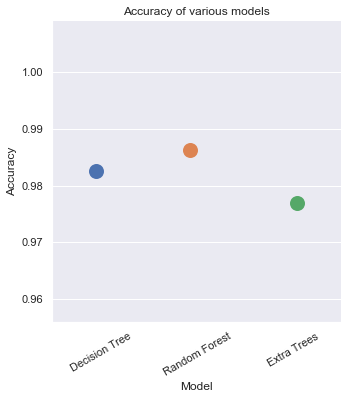

In [135]:
g = sns.catplot(data=acc_df.reset_index(), x='index', y='Accuracy', s=15)
plt.xlabel('Model')
g.set_xticklabels(rotation=30)
plt.title('Accuracy of various models')

### # 1 Ensemble method: voting classifier

Regrouping three different classifiers

In [136]:
voting_clf = VotingClassifier(
    estimators=[('tree', tree_clf), ('forest', forest_clf), ('extra', extra_clf)],
    voting='hard')

Fitting the voting classifier to the data

In [137]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort=False,
                                                     random_state=None,
                                                     splitter='best')),
    

Making predictions

In [138]:
y_pred = voting_clf.predict(X_test)

Evaluating the predictions

In [139]:
voting_accuracy = accuracy_score(y_pred, y_test)
print('With the voting classifier using all the previous models, we have reached a' + 
      ' %f%% accuracy'%(voting_accuracy*1_00))

With the voting classifier using all the previous models, we have reached a 98.812500% accuracy


In [140]:
acc_df = pd.concat([acc_df, pd.DataFrame([voting_accuracy], columns=['Accuracy'], index=['Voting'])], sort=False, axis=0)
acc_df

,Accuracy
Decision Tree,0.982500
Random Forest,0.986250
Extra Trees,0.976875
Voting,0.988125


Text(0.5, 1, 'Accuracy of various models')

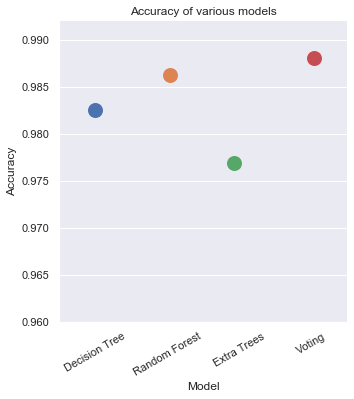

In [141]:
g=sns.catplot(data=acc_df.reset_index(), x='index', y='Accuracy', s=15)
plt.xlabel('Model')
g.set_xticklabels(rotation=30)
plt.ylim([960e-3, 992e-3])
plt.title('Accuracy of various models')

The voting classifier wins!

### # 2 Ensemble method: bagging classifier

Setting up the classifier that will use bootstrap samples

In [142]:
bag_clf = BaggingClassifier(forest_clf, n_estimators=20, max_features=80)

Fitting the model

In [143]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=22,
                                                        max_features=80,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=2,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=200,
                                                        n_jobs=-1,
               

Making predictions

In [144]:
y_pred = bag_clf.predict(X_test)

Evaluating the predictions

In [145]:
bag_accuracy = accuracy_score(y_test, y_pred)
print('With the bagging classifier, we have reached a %f%% accuracy'%(bag_accuracy*1_00))

With the bagging classifier, we have reached a 98.312500% accuracy


In [146]:
acc_df = pd.concat([acc_df, pd.DataFrame([bag_accuracy], columns=['Accuracy'], index=['Bagging'])], axis=0)
acc_df

,Accuracy
Decision Tree,0.982500
Random Forest,0.986250
Extra Trees,0.976875
Voting,0.988125
Bagging,0.983125


Text(0.5, 1, 'Accuracy of various models')

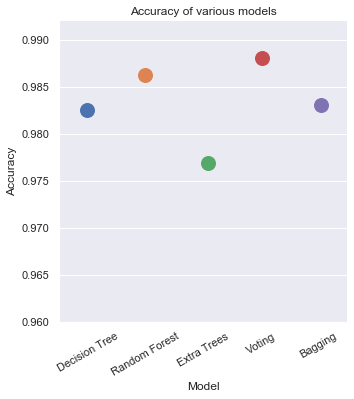

In [147]:
g=sns.catplot(data=acc_df.reset_index(), x='index', y='Accuracy', s=15)
plt.xlabel('Model')
g.set_xticklabels(rotation=30)
plt.ylim([960e-3, 992e-3])
plt.title('Accuracy of various models')

### # 3 Ensemble method: pasting classifier

A pasting classifier is like bagging, but instead of sampling training instances with replacement, it does no replacement

In [148]:
paste_clf = BaggingClassifier(forest_clf, n_estimators=20, max_features=80,
                           bootstrap=False)

Fitting the model to the data

In [149]:
paste_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=22,
                                                        max_features=80,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=2,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=200,
                                                        n_jobs=-1,
               

Making predictions

In [150]:
y_pred = paste_clf.predict(X_test)

Evaluating the predictions

In [151]:
paste_accuracy = accuracy_score(y_test, y_pred)
print('With the pasting classifier, we have reached a %f%% accuracy'%(paste_accuracy*1_00))

With the pasting classifier, we have reached a 98.750000% accuracy


Final scores

In [152]:
acc_df = pd.concat([acc_df, pd.DataFrame([paste_accuracy], columns=['Accuracy'], index=['Pasting'])], axis=0)
acc_df

,Accuracy
Decision Tree,0.982500
Random Forest,0.986250
Extra Trees,0.976875
Voting,0.988125
Bagging,0.983125
Pasting,0.987500


Text(0.5, 1, 'Accuracy of various models')

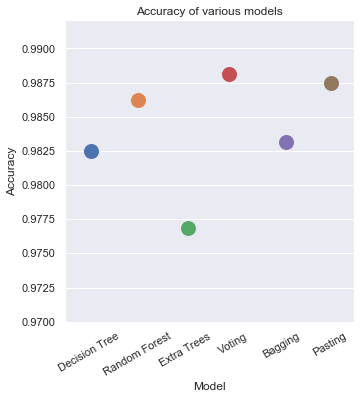

In [156]:
g=sns.catplot(data=acc_df.reset_index(), x='index', y='Accuracy', s=15)
plt.xlabel('Model')
g.set_xticklabels(rotation=30)
plt.ylim([970e-3, 992e-3])
plt.title('Accuracy of various models')

In order of accuracy: <br>
1. Voting Classifier <br>
2. Pasting Classifier <br>
3. Random Forest <br>
4. Bagging Classifier <br>
5. Decision Tree Classifier <br>
6. Extra Tree Classifier <br>

### Sorted Methods by Accuracy Score

In [155]:
acc_df.sort_values(by='Accuracy', ascending=False)

,Accuracy
Voting,0.988125
Pasting,0.987500
Random Forest,0.986250
Bagging,0.983125
Decision Tree,0.982500
Extra Trees,0.976875
